# Publication outputs
This notebook extracts plots and tables from the model and grid files, which were cosmetically improved prior to inclusion in the publication.
It includes:
* Regression model parameter tables and regression plots
* LISST-200X Particle Size distribution plot
* Optical misalignment plot
* Summary plot and table of the in-situ data
* Predicted SPMC map and vertical cutaway plot
* Comparison plot of predicted SPMC profiles with Niskin Bottle SPMC station measurements
* Colorbar for Potree viewer plot
* Optical Misalignment plot
* Table of predicted SPMC statistics per campaign


In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from math import floor
from scipy import signal
import os
import re
from glob import glob
from joblib import load
import matplotlib.pyplot as plt
from matplotlib import rc
rc("pdf", fonttype=42)
import statsmodels.api as sm
from timbers_code.utils import create_folder_if_absent
from timbers_code.mbes_preprocessing import Dim2RgbaMapper

## Set the parameters
### Regression model parameter tables and regression plots
* model_files: regression model files
* filename_model_table: output filename for table of regression model parameters
* filepath_regplots: output path for regression plots

### LISST-200X PSD plot
* lisst_size_classes: path to the file that defines the size classes. From LISST-200X Manual
* sensor_data_tables: path where in-situ sensor data is stored
* summer_lisst_files: list of in-situ sensor data files collected in summer
* winter_lisst_files: list of in-situ sensor data files collected in winter
* psd_plot_depth_bins: depth bins over which to average the particle size distribution (PSD) in the PSD plot
* filepath_lisst_psd_plot: output file for the PSD plot

### Summary plot and table of the in-situ data
* lisst_summary_parameters: Parameters to include in the summary plot and table of the in-situ data 
* filepath_lisst_summaryplot: Output path for the summary plot of the in-situ data 
* filepath_lisst_summarytable: Output path for the summary table of the in-situ data
### Predicted SPMC map and vertical cutaway plot
* raster_path: path to netCDF files of gridded predicted TVC and SPMC
* campaign_to_plot: which campaign to plot
* spmc_assmeblage_files_to_plot: list of netCDF file with predicted SPMC to include in the plot
* variable_to_plot: which statistic of the predicted SPMC to plot
* z_to_plot: depth slice to plot in map view
* y_to_plot: vertical slice to plot in side view
* colormaps: colormaps and ranges to use in the plot
* filepath_spmc_plot: output file for predicted SPMC map and vertical cutaway plot
### Comparison plot of predicted SPMC profiles with Niskin Bottle SPMC station measurements
* spmc_assmeblage_files_for_profileplot: list of netCDF file with predicted SPMC to include in the plot
* variable_for_profileplot: which statistic of the predicted SPMC to plot
* spmc_profile_plot_spmc_bins: SPMC bins to plot
* spmc_profile_plot_depth_bins: depth bins to plot
* niskin_samples: data file of Niskin Bottle SPMC station measurements
* tide_correction_files: file paths to tide correction tables based on RTK data from the vessel
* sample_interval: sample interval of LISST-200X, used to resample the tide correction
* z_coord: the header for the input depth to use for tide correction
* z_coord_LAT: the header for the tide corrected depth (in LAT)
* niskin_spmc_variable: the header for the Niskin Bottle SPMC measurement
* filepath_spmc_profile_plot: output file for the plot of predicted SPMC profiles with Niskin Bottle SPMC station measurements
* filename_spmc_table: output filename for table of SPMC statistics per campaign
* filename_spmc_table_averages: output filename for table of SPMC statistics averaged over the campaigns

### Colorbar for Potree viewer plot
* potree_cmap_name: colorscale used in potree colorscale as in `0_mbes_preprocessing.ipynb`
* potree_value_db_min: minimum Sv value used in potree colorscale as in `0_mbes_preprocessing.ipynb`
* potree_value_db_max: maximum Sv value used in potree colorscale as in `0_mbes_preprocessing.ipynb`
* potree_cmap_dimension: label for the colorscale
* filepath_potree_colobar: output filename for colorbar plot

### Optical Misalignment plot
* unprocessed_lisst_file_october: unprocessed LISST-200x file with optical misalignment from october campaign
* unprocessed_lisst_file_february: unprocessed LISST-200x file with optical misalignment from february campaign
* unprocessed_lisst_datetime_columns: column headers that define the timestamp for the unprocessed LISST-200x data
* unprocessed_lisst_z_coord: column headers for the depth coordinate of the unprocessed LISST-200x data
* filepath_misalignment_plot: output filename for the optical misalignment plot

### Table of predicted SPMC statistics per campaign
* filepath_spmc_average_table: output filename for table of predicted SPMC statistics per campaign

In [2]:
# regression model parameter tables and regression plots 
model_files = glob('data/models/*.joblib')
filename_model_table = 'publication_output/model_table.csv'
filepath_regplots = 'publication_output/regressionplots'
# LISST-200X PSD plot
lisst_size_classes = 'sensor_data/lisst_size_classes.csv'
sensor_data_tables = 'sensor_data/'
summer_lisst_files = [glob(f'{sensor_data_tables}/{campaign}/*w_grainsize_tide_corrected.csv')[0] for campaign in ['Timbers_20-690','Timbers_21-430','Timbers_21-550_KW','Timbers_21-550_WD']]
winter_lisst_files = [glob(f'{sensor_data_tables}/{campaign}/*w_grainsize_tide_corrected.csv')[0] for campaign in ['Timbers_20-690','Timbers_21-092','Timbers_21-160',]]
psd_plot_depth_bins = list(range(-22,2,2))
filepath_lisst_psd_plot = 'publication_output/lisst_psd_plot.pdf'
# Summary plot and table of the in-situ data
lisst_summary_parameters = ['Average of Turbidity_NTU','Total Volume Concentration [ppm]','D50', 'PSD_slope']
filepath_lisst_summaryplot = 'publication_output/lisst_summaryplot'
filepath_lisst_summarytable = 'publication_output/lisst_summarytable'
# Predicted SPMC map and vertical cutaway plot
raster_path = 'G:/Algorithm2/predictions_final'
campaign_to_plot = '21160'
spmc_assmeblage_files_to_plot = [glob(f'{raster_path}/*_{campaign_to_plot}/*_SPMC_{interval}.nc')[0] for interval in ['(0.0,_459.0]','(3.0,_20.0]','(20.0,_200.0]']]
variable_to_plot = 'mean'
z_to_plot = -14.
y_to_plot = 5681469
filepath_spmc_plot = f'publication_output/spmc_plots_campaign_{campaign_to_plot}.pdf' 
colormaps = [{'cmap':'viridis', 'vmin': 15, 'vmax':65},
             {'cmap':'plasma', 'vmin': 0, 'vmax':15},
             {'cmap':'plasma', 'vmin': 0, 'vmax':15}]
# Comparison plot of predicted SPMC profiles with Niskin Bottle SPMC station measurements
spmc_assmeblage_files_for_profileplot = glob(f'{raster_path}/*/*_SPMC_(0.0,_459.0].nc')
variable_for_profileplot = 'SPMC_(0.0,_459.0]_mean'
spmc_profile_plot_spmc_bins = np.linspace(0,100,100)
spmc_profile_plot_depth_bins = list(range(-22,2,1))
niskin_samples = 'sensor_data/StationData/SPMandTurbidity.csv'
## tide correction parameters for Niskin
tide_correction_files = glob('sensor_data/TideCorrection/Waterniveau_LAT_*.xlsx')
sample_interval = '1s'
z_coord = 'Depth (m)'
z_coord_LAT = 'depth_m_LAT'
niskin_spmc_variable = 'SPM concentration (mg/L)'
filepath_spmc_profile_plot = 'publication_output/spmc_profile_plot.pdf'
# gridded predicition summary tables and plots
filename_spmc_table = 'publication_output/predicted_spmc_stats_per_campaign.csv'
filename_spmc_table_averages = 'publication_output/predicted_spmc_stats_per_campaign_averaged.csv'
# colorbar plot potree figures
## use default settings used in the mbes preprocessing
potree_cmap_name = 'jet'
potree_value_db_min = -100
potree_value_db_max = 0
potree_cmap_dimension = 'Acoustic Backscatter Intensity (dB)'
filepath_potree_colobar = 'publication_output/potree_colorbar.pdf'
# Optical Misalignment plot
unprocessed_lisst_file_october = f'{sensor_data_tables}Timbers_20-690/Sensors_20-690.csv'
unprocessed_lisst_file_february = f'{sensor_data_tables}Timbers_21-092/Sensors_21-092.csv'
unprocessed_lisst_datetime_columns = ['year', 'Month', 'day', 'hour', 'minute', 'second']
unprocessed_lisst_z_coord = 'Depth in calibrated units [m]'
filepath_misalignment_plot = 'publication_output/misalignment_plot.pdf'
# spmc average table of mean, lower limit, upper limit
filepath_spmc_average_table = 'publication_output/spmc_average_table.csv'

## Regression model parameter tables and regression plots

### Table of regression model parameters

In [3]:
results = []
for model_file in model_files:
    model = load(model_file)
    results.append({
        'model_file':os.path.basename(model_file),
        'y_dimension': model._results.model.endog_names,
        # 'y_fitted_minimum':model.get_prediction(model._results.model.exog[model._results.model.exog[:,1].argmin()]).summary_frame()['mean'][0],
        # 'y_fitted_minimum_lower_ci':model.get_prediction(model._results.model.exog[model._results.model.exog[:,1].argmin()]).summary_frame()['obs_ci_lower'][0],
        # 'y_fitted_minimum_upper_ci':model.get_prediction(model._results.model.exog[model._results.model.exog[:,1].argmin()]).summary_frame()['obs_ci_upper'][0],
        # 'y_fitted_maximum':model.get_prediction(model._results.model.exog[model._results.model.exog[:,1].argmax()]).summary_frame()['mean'][0],
        # 'y_fitted_maximum_lower_ci':model.get_prediction(model._results.model.exog[model._results.model.exog[:,1].argmax()]).summary_frame()['obs_ci_lower'][0],
        # 'y_fitted_maximum_upper_ci':model.get_prediction(model._results.model.exog[model._results.model.exog[:,1].argmax()]).summary_frame()['obs_ci_upper'][0],
        'model_n':model._results.nobs,
        # 'model_adj_rsquared':model._results.rsquared_adj, # update this to the test R2 from the html's
        'alpha': model._results.params[0],
        'beta': model._results.params[1],
        'alpha_stderror': model._results.bse[0],
        'beta_stderror': model._results.bse[1],
        # 'alpha_p_value': model._results.pvalues[0],
        'beta_p_value': model._results.pvalues[1],
        'standard_error_of_regression':np.sqrt(model.scale)
       })
output = pd.DataFrame(results).set_index('model_file')
# output = pd.concat([output,
#                    output[['y_fitted_minimum','y_fitted_minimum_lower_ci','y_fitted_minimum_upper_ci','y_fitted_maximum','y_fitted_maximum_lower_ci','y_fitted_maximum_upper_ci']].applymap(lambda x: 10**x).add_prefix('exp10_')],
#                    axis = 1)
output.to_csv(filename_model_table)
output

,y_dimension,model_n,alpha,beta,alpha_stderror,beta_stderror,beta_p_value,standard_error_of_regression
model_file,,,,,,,,
"model_20690_21430_21550_shipaverage_value_db_vs_Log_TVC_(200.0,_420.0]_tide_corrected.joblib","Log10 TVC_(200.0, 420.0]",6529.0,1.541881,0.005581,0.053741,0.000765,3.274849e-13,0.211147
model_20690_21092_21160_shipaverage_value_db_vs_Log_Average_of_Turbidity_NTU_tide_corrected.joblib,Log10 Average of Turbidity_NTU,12024.0,5.978754,0.073959,0.090079,0.001248,0.000000e+00,0.289865
model_20690_21430_21550_shipaverage_value_db_vs_Log_Total_Volume_Concentration_[ppm]_tide_corrected.joblib,Log10 Total Volume Concentration [ppm],6529.0,3.634998,0.029360,0.028725,0.000411,0.000000e+00,0.120953
"model_20690_21430_21550_shipaverage_value_db_vs_Log_TVC_(0.0,_3.0]_tide_corrected.joblib","Log10 TVC_(0.0, 3.0]",784.0,-6.499393,-0.072574,0.560772,0.008158,3.970590e-18,0.331186
"model_20690_21430_21550_shipaverage_value_db_vs_Log_TVC_(3.0,_20.0]_tide_corrected.joblib","Log10 TVC_(3.0, 20.0]",6529.0,4.134136,0.052772,0.020494,0.000293,0.000000e+00,0.086295
"model_20690_21430_21550_shipaverage_value_db_vs_Log_TVC_(20.0,_200.0]_tide_corrected.joblib","Log10 TVC_(20.0, 200.0]",6529.0,4.134178,0.040452,0.024883,0.000355,0.000000e+00,0.103137


### Regression plots

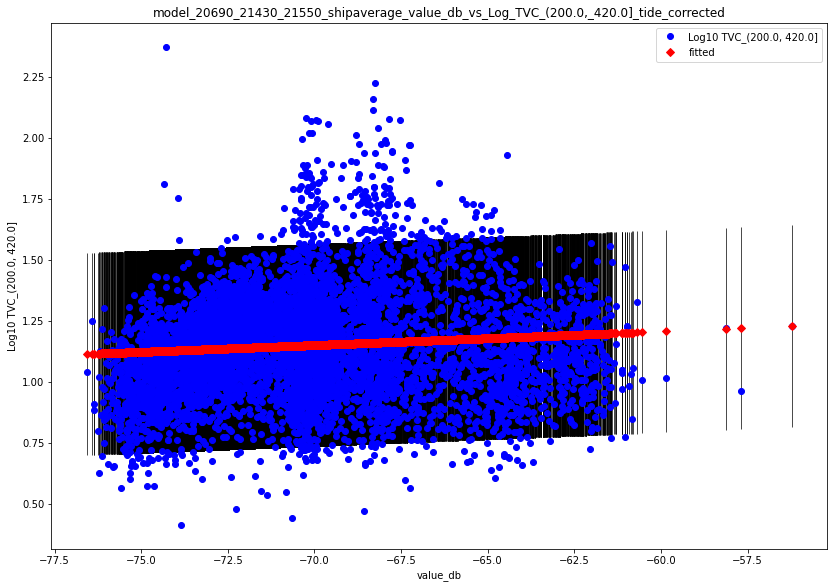

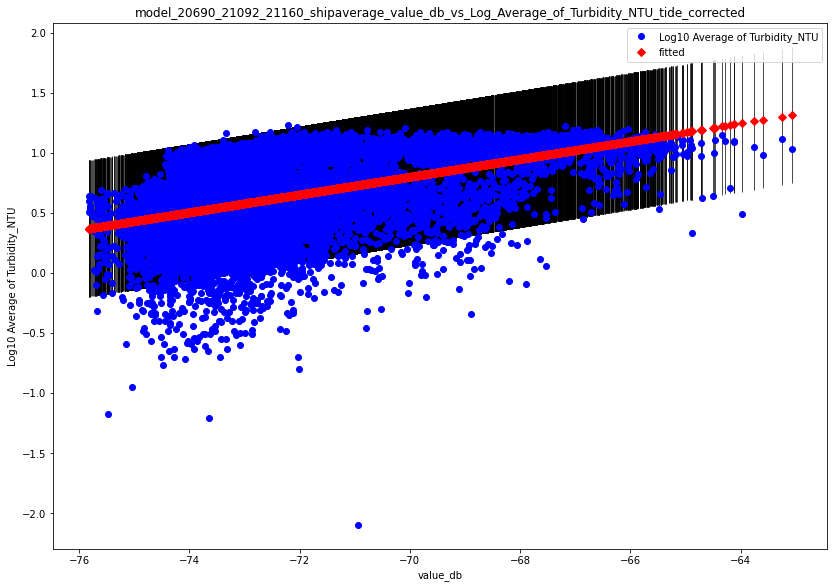

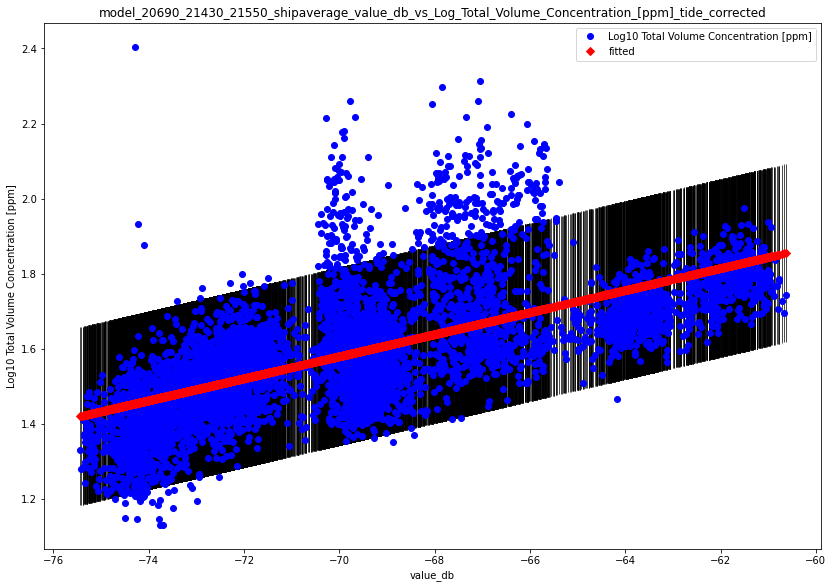

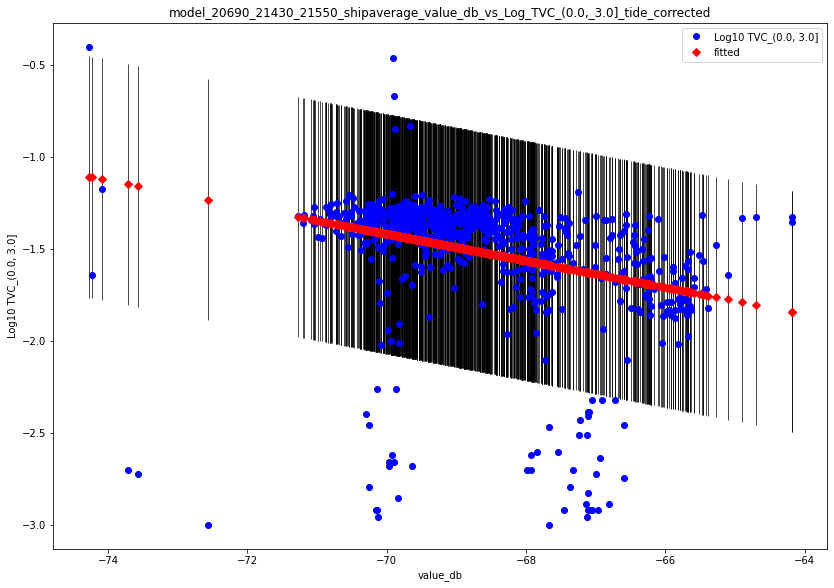

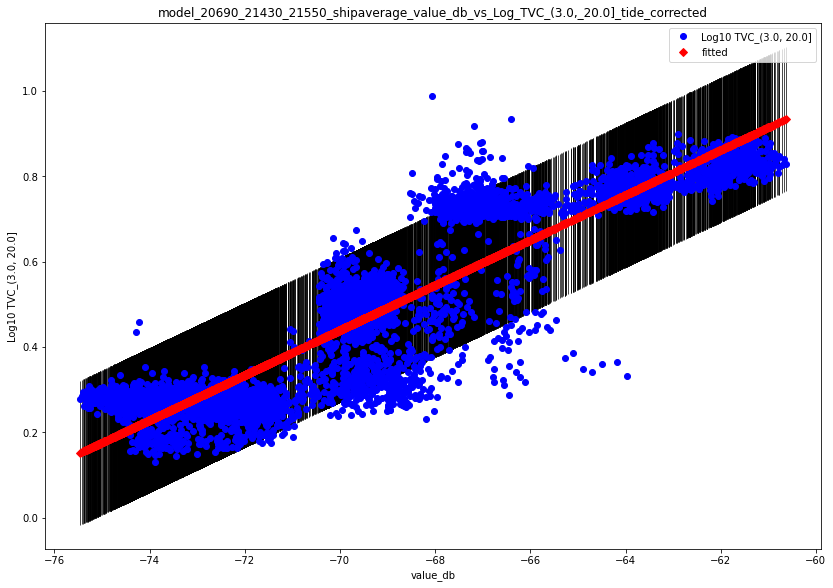

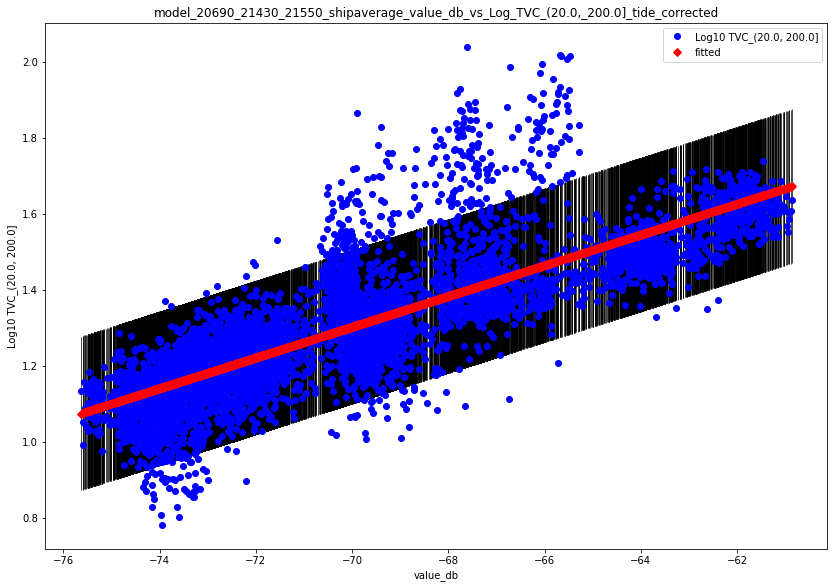

In [4]:
for model_file in model_files:
    plot_title= os.path.splitext(os.path.basename(model_file))[0]
    fig, ax = plt.subplots(figsize = (11.69, 8.27))
    sm.graphics.plot_fit(load(model_file), 'x1', ax=ax)
    ax.set_xlabel('value_db')
    ax.set_title(plot_title)
    fig.tight_layout()
    file_name = f'{filepath_regplots}/{plot_title}.pdf'
    fig.savefig(file_name,bbox_inches='tight')

## LISST-200X PSD plot


### Read in data files

In [5]:
# read in lisst size classes:
size_classes = pd.read_csv(lisst_size_classes)

In [6]:
# Read in the summer lisst data
summer_lisst_df = pd.concat([pd.read_csv(summer_lisst_file) for summer_lisst_file in summer_lisst_files]).reset_index(drop=True)
summer_lisst_df

,Volume conc (microl/l) 1,Volume conc (microl/l) 2,Volume conc (microl/l) 3,Volume conc (microl/l) 4,Volume conc (microl/l) 5,Volume conc (microl/l) 6,Volume conc (microl/l) 7,Volume conc (microl/l) 8,Volume conc (microl/l) 9,Volume conc (microl/l) 10,...,mean_geom_um,mode_1,mode_2,mode_3,skewness_geom_um,sorting_geom_um,Speed Over Ground,mode_4,mode_5,mode_6
0,0.0,0.0,0.0,0.001693,0.010450,0.028935,0.034544,0.051928,0.108506,0.210081,...,104.701597,324.0,72.2,NaN,-0.791440,3.148186,NaN,NaN,NaN,NaN
1,0.0,0.0,0.0,0.002053,0.012037,0.031857,0.036917,0.053884,0.110846,0.212779,...,99.244080,324.0,61.2,22.7,-0.705776,3.372759,NaN,NaN,NaN,NaN
2,0.0,0.0,0.0,0.002030,0.011855,0.031117,0.035783,0.052048,0.106961,0.204929,...,102.292304,324.0,61.2,NaN,-0.662788,3.483028,NaN,NaN,NaN,NaN
3,0.0,0.0,0.0,0.001925,0.011338,0.029985,0.034598,0.050449,0.104154,0.200532,...,88.103853,324.0,61.2,NaN,-0.491848,3.261561,NaN,NaN,NaN,NaN
4,0.0,0.0,0.0,0.001697,0.010345,0.028184,0.033250,0.049851,0.104812,0.205125,...,92.144137,273.0,61.2,NaN,-0.631349,3.224868,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12883,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12884,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12885,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12886,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Read in the winter lisst data
winter_lisst_df = pd.concat([pd.read_csv(winter_lisst_file) for winter_lisst_file in winter_lisst_files]).reset_index(drop=True)
winter_lisst_df

C:\Users\NORE~1.PRA\AppData\Local\Temp/ipykernel_15892/3130101664.py:1: DtypeWarning: Columns (66,74) have mixed types.Specify dtype option on import or set low_memory=False.
  winter_lisst_df = pd.concat([pd.read_csv(winter_lisst_file) for winter_lisst_file in winter_lisst_files]).reset_index(drop=True)


,Volume conc (microl/l) 1,Volume conc (microl/l) 2,Volume conc (microl/l) 3,Volume conc (microl/l) 4,Volume conc (microl/l) 5,Volume conc (microl/l) 6,Volume conc (microl/l) 7,Volume conc (microl/l) 8,Volume conc (microl/l) 9,Volume conc (microl/l) 10,...,Trask(So),kurtosis_geom_um,mean_geom_um,mode_1,mode_2,mode_3,skewness_geom_um,sorting_geom_um,"TVC_(20.0, 152.0]",Speed Over Ground
0,0.000000,0.000000,0.000000,0.001693,0.010450,0.028935,0.034544,0.051928,0.108506,0.210081,...,0.424694,2.739529,104.701597,324.0,72.20,NaN,-0.791440,3.148186,NaN,NaN
1,0.000000,0.000000,0.000000,0.002053,0.012037,0.031857,0.036917,0.053884,0.110846,0.212779,...,0.381511,2.432244,99.244080,324.0,61.20,22.7,-0.705776,3.372759,NaN,NaN
2,0.000000,0.000000,0.000000,0.002030,0.011855,0.031117,0.035783,0.052048,0.106961,0.204929,...,0.361518,2.321165,102.292304,324.0,61.20,NaN,-0.662788,3.483028,NaN,NaN
3,0.000000,0.000000,0.000000,0.001925,0.011338,0.029985,0.034598,0.050449,0.104154,0.200532,...,0.384815,2.348491,88.103853,324.0,61.20,NaN,-0.491848,3.261561,NaN,NaN
4,0.000000,0.000000,0.000000,0.001697,0.010345,0.028184,0.033250,0.049851,0.104812,0.205125,...,0.398134,2.451601,92.144137,273.0,61.20,NaN,-0.631349,3.224868,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29981,0.001867,0.007887,0.020495,0.053715,0.112043,0.153098,0.158774,0.227495,0.356077,0.533891,...,0.602719,3.431840,36.909155,51.9,NaN,NaN,-0.718013,2.286848,31.478592,1.9
29982,0.002380,0.009415,0.023289,0.057522,0.113030,0.147319,0.149498,0.210364,0.322681,0.475930,...,0.601012,3.584784,40.383465,61.2,NaN,NaN,-0.785850,2.286061,34.681780,2.0
29983,0.003098,0.011378,0.026682,0.061988,0.114946,0.143698,0.143178,0.196958,0.293810,0.421366,...,0.602370,3.910854,47.616908,61.2,3.11,NaN,-0.952607,2.314594,38.589600,2.0
29984,0.002170,0.008712,0.021809,0.054682,0.109226,0.144562,0.148235,0.210803,0.325895,0.484062,...,0.602561,3.618725,42.545830,61.2,NaN,NaN,-0.821029,2.297524,37.019460,1.7


### Normalize and bin the Volume Concentration data


#### In summer

In [8]:
# normalize the Volumce Concentrations
summer_lisst_df_VC_norm = summer_lisst_df.filter(like='Volume conc (microl/l)').div(summer_lisst_df.filter(like='Volume conc (microl/l)').sum(axis=1), axis = 0)
# average the normalized Volume concentration in 2 m depth bins
summer_lisst_df_VC_norm_binned = summer_lisst_df_VC_norm.groupby(pd.cut(summer_lisst_df['Lisst_depth_m_LAT'], bins = psd_plot_depth_bins)).mean()
# transpose the table and rplace volume conc classes with median size classes
summer_lisst_df_VC_norm_binned = summer_lisst_df_VC_norm_binned.transpose().set_index(size_classes.Median)
summer_lisst_df_VC_norm_binned

Lisst_depth_m_LAT,"(-22, -20]","(-20, -18]","(-18, -16]","(-16, -14]","(-14, -12]","(-12, -10]","(-10, -8]","(-8, -6]","(-6, -4]","(-4, -2]","(-2, 0]"
Median,,,,,,,,,,,
1.21,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00
1.60,0.000000,0.000000,0.000000,0.000000,0.000000,5.468321e-08,1.378517e-08,0.000000,0.000000,0.000000,0.000000e+00
1.89,0.000000,0.000000,0.000000,0.000000,0.000000,1.833338e-07,1.038746e-07,0.000000,0.000000,0.000000,0.000000e+00
2.23,0.000002,0.000002,0.000003,0.000005,0.000008,4.183266e-06,5.432225e-06,0.000006,0.000007,0.000004,5.836691e-08
2.63,0.000043,0.000039,0.000028,0.000033,0.000048,2.402512e-05,3.190860e-05,0.000035,0.000042,0.000022,3.958053e-07
3.11,0.000152,0.000135,0.000085,0.000093,0.000128,6.400313e-05,8.302450e-05,0.000092,0.000110,0.000058,1.559117e-06
3.67,0.000224,0.000193,0.000108,0.000109,0.000144,7.396492e-05,9.318526e-05,0.000103,0.000125,0.000068,3.304908e-06
4.33,0.000422,0.000359,0.000184,0.000174,0.000216,1.227608e-04,1.623258e-04,0.000188,0.000234,0.000149,4.183455e-05
5.11,0.001027,0.000905,0.000503,0.000476,0.000553,3.791246e-04,5.396682e-04,0.000655,0.000846,0.000637,3.397816e-04


#### In winter

In [9]:
winter_lisst_df = pd.concat([pd.read_csv(winter_lisst_file) for winter_lisst_file in winter_lisst_files]).reset_index(drop=True)
# normalize the Volumce Concentrations
winter_lisst_df_VC_norm = winter_lisst_df.filter(like='Volume conc (microl/l)').div(winter_lisst_df.filter(like='Volume conc (microl/l)').sum(axis=1), axis = 0)
# average the normalized Volume concentration in 2 m depth bins
winter_lisst_df_VC_norm_binned = winter_lisst_df_VC_norm.groupby(pd.cut(winter_lisst_df['Lisst_depth_m_LAT'], bins = psd_plot_depth_bins)).mean()
# transpose the table and rplace volume conc classes with median size classes
winter_lisst_df_VC_norm_binned =  winter_lisst_df_VC_norm_binned.transpose().set_index(size_classes.Median)
winter_lisst_df_VC_norm_binned

C:\Users\NORE~1.PRA\AppData\Local\Temp/ipykernel_15892/3550438507.py:1: DtypeWarning: Columns (66,74) have mixed types.Specify dtype option on import or set low_memory=False.
  winter_lisst_df = pd.concat([pd.read_csv(winter_lisst_file) for winter_lisst_file in winter_lisst_files]).reset_index(drop=True)


Lisst_depth_m_LAT,"(-22, -20]","(-20, -18]","(-18, -16]","(-16, -14]","(-14, -12]","(-12, -10]","(-10, -8]","(-8, -6]","(-6, -4]","(-4, -2]","(-2, 0]"
Median,,,,,,,,,,,
1.21,0.000001,0.000020,0.000013,0.000040,0.000048,0.000056,0.000061,0.000062,0.000059,0.000069,0.000091
1.60,0.000041,0.000069,0.000065,0.000143,0.000163,0.000185,0.000198,0.000201,0.000196,0.000223,0.000283
1.89,0.000129,0.000154,0.000179,0.000330,0.000368,0.000407,0.000433,0.000440,0.000436,0.000487,0.000606
2.23,0.000429,0.000370,0.000525,0.000785,0.000851,0.000917,0.000966,0.000988,0.001000,0.001093,0.001320
2.63,0.000376,0.000336,0.000568,0.000763,0.000797,0.000903,0.000914,0.000904,0.001008,0.001056,0.001858
3.11,0.000396,0.000321,0.000717,0.000915,0.000946,0.001090,0.001089,0.001080,0.001250,0.001272,0.002270
3.67,0.000438,0.000368,0.000776,0.000958,0.000984,0.001127,0.001127,0.001117,0.001291,0.001313,0.002301
4.33,0.000847,0.000799,0.001343,0.001568,0.001613,0.001793,0.001827,0.001820,0.002042,0.002096,0.003337
5.11,0.001451,0.001413,0.002303,0.002563,0.002621,0.002882,0.002942,0.002933,0.003284,0.003342,0.005084


### Create the PSD plots for winter and summer

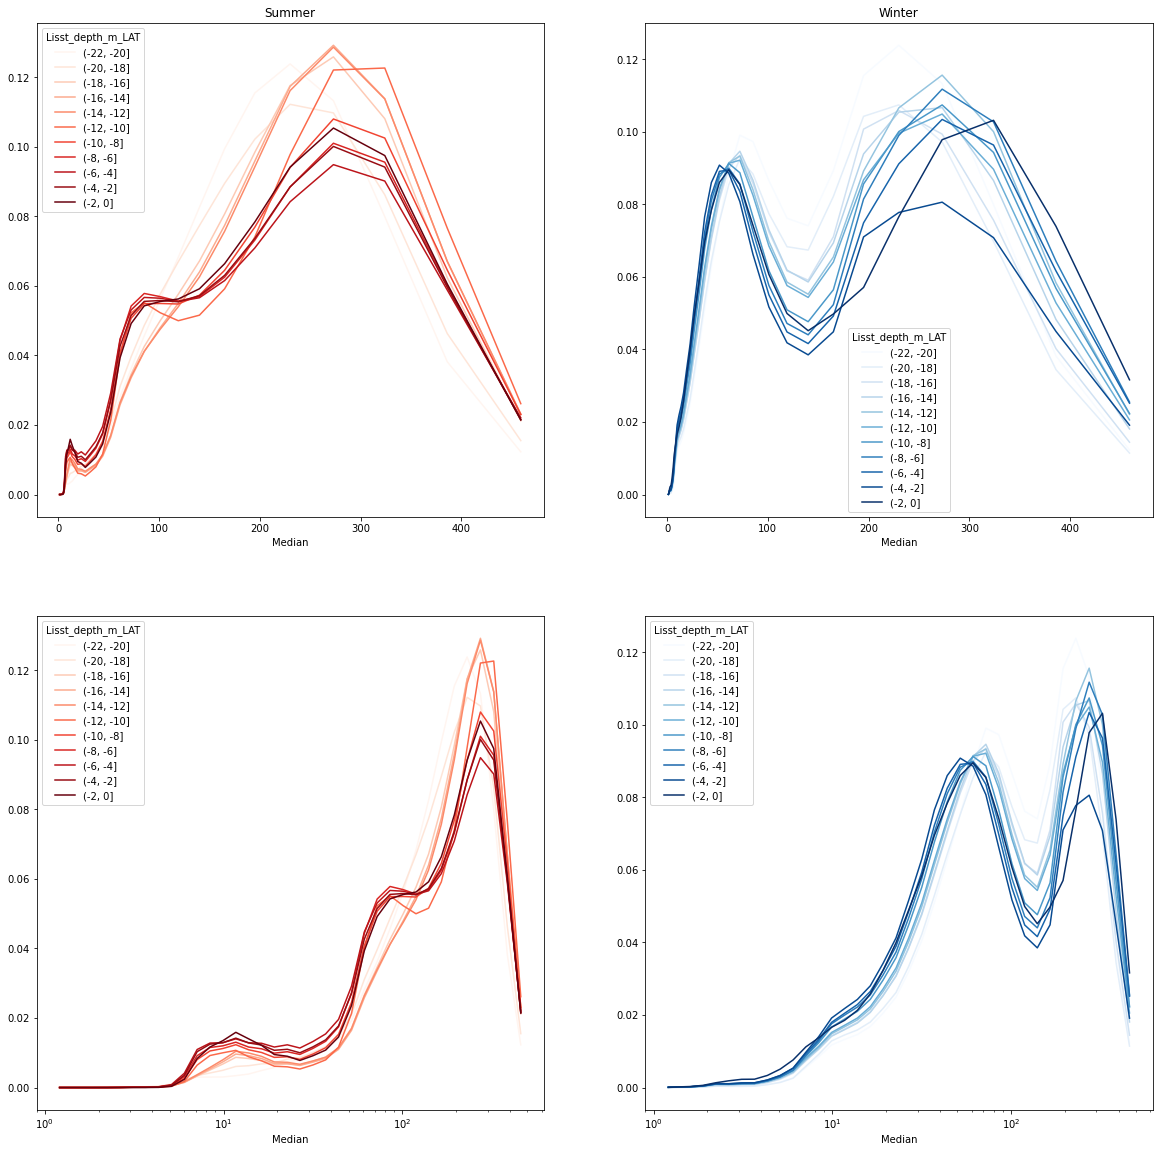

In [10]:
fig, ax = plt.subplots(2,2,figsize = (20,20))
summer_lisst_df_VC_norm_binned.plot(ax = ax[0,0], colormap='Reds')
summer_lisst_df_VC_norm_binned.plot(ax = ax[1,0], colormap='Reds')
ax[0,0].set_title('Summer')
ax[1,0].set_xscale('log')
winter_lisst_df_VC_norm_binned.plot(ax = ax[0,1], colormap='Blues')
winter_lisst_df_VC_norm_binned.plot(ax = ax[1,1], colormap='Blues')
ax[0,1].set_title('Winter')
ax[1,1].set_xscale('log')
fig.savefig(filepath_lisst_psd_plot,bbox_inches='tight')

## Summary plot and table of the in-situ data

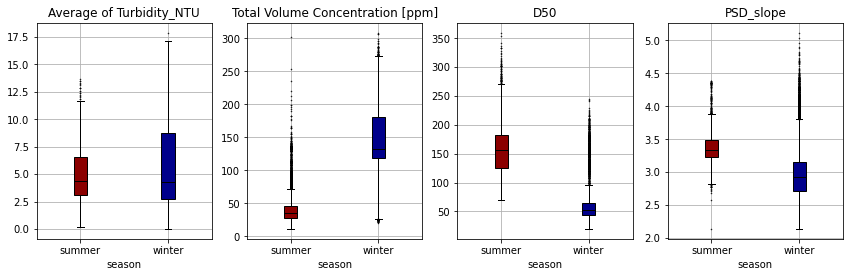

In [11]:
summer_lisst_df['season'] = 'summer'
winter_lisst_df['season']= 'winter'
no_of_plots = len(lisst_summary_parameters)
fig, ax = plt.subplots(1,no_of_plots,figsize = (14,4))
for i in range(no_of_plots):
    bp_dict = pd.concat([summer_lisst_df,winter_lisst_df]).boxplot(column = lisst_summary_parameters[i],
                                                         by = 'season',
                                                         ax = ax[i],return_type='both',
                                                         patch_artist=True,
                                                         boxprops = {'linewidth':1, 'color':'black'},
                                                         medianprops = {'linewidth':1, 'color':'black'},
                                                         whiskerprops = {'linewidth':1, 'color':'black'},
                                                         flierprops={'marker': '.', 'markersize': 1})
    colors = ['darkred', 'darkblue']
    for row_key, (_,row) in bp_dict.iteritems():
        for i,box in enumerate(row['boxes']):
            box.set_facecolor(colors[i])
fig.suptitle('')
fig.savefig(filepath_lisst_summaryplot+'.pdf', bbox_inches = 'tight')

In [12]:
lisst_summary_table = pd.concat([summer_lisst_df,winter_lisst_df])[lisst_summary_parameters+['season']].groupby('season').quantile([0.25,0.5,0.75]).reset_index().rename(columns = {'level_1':'quantile'})
lisst_summary_table.to_csv(filepath_lisst_summarytable+'.csv', index = False)
lisst_summary_table

,season,quantile,Average of Turbidity_NTU,Total Volume Concentration [ppm],D50,PSD_slope
0,summer,0.25,3.106,27.29375,124.570647,3.221681
1,summer,0.50,4.388,35.22865,156.904222,3.336970
2,summer,0.75,6.544,45.21525,182.983429,3.487602
3,winter,0.25,2.760,119.17675,43.505406,2.712692
4,winter,0.50,4.280,131.96850,53.189185,2.928867
5,winter,0.75,8.704,180.97575,64.419355,3.150879


## Predicted SPMC map and vertical cutaway plot for campaign 21-160

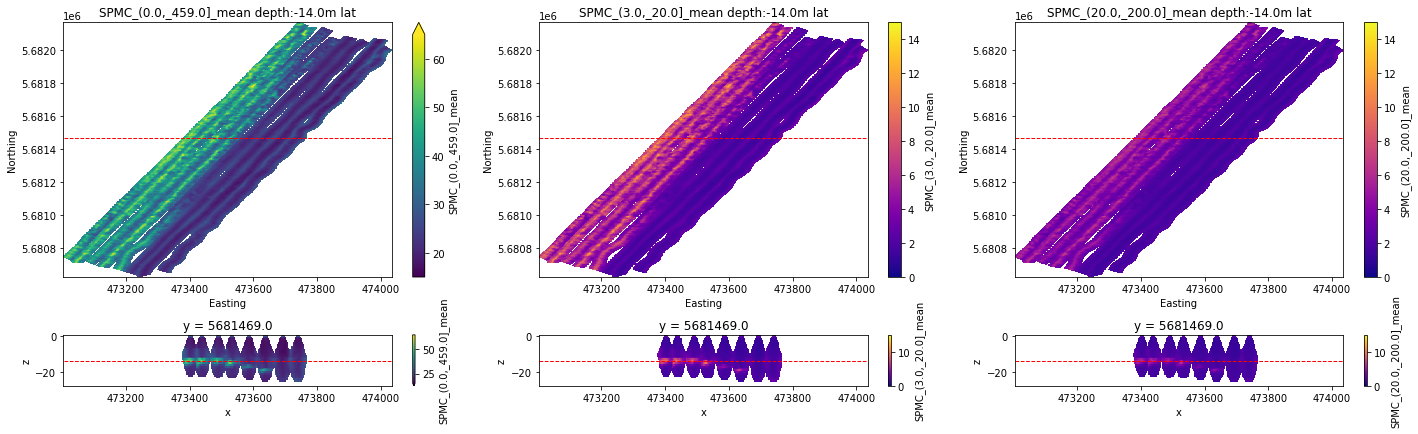

In [13]:
fig, ax = plt.subplots(2,3,figsize = (20,6),gridspec_kw={'height_ratios': [5, 1]})
for i in range(len(spmc_assmeblage_files_to_plot)):
    raster = xr.open_dataset(spmc_assmeblage_files_to_plot[i])
    var_to_plot = [var for var in raster.data_vars if variable_to_plot in var][0]
    raster[var_to_plot].sel(z=z_to_plot).plot(x = 'x', y = 'y', ax = ax[0,i], cmap = colormaps[i]['cmap'], vmin = colormaps[i]['vmin'], vmax = colormaps[i]['vmax'], rasterized=True)
    ax[0,i].set_title(f'{var_to_plot} depth:{z_to_plot}m lat')
    ax[0,i].hlines(y = y_to_plot, xmin = raster.x.data[0], xmax = raster.x.data[-1], color= 'red', linestyles = 'dashed',linewidth=1)
    ax[0,i].set_xlabel('Easting')
    ax[0,i].set_ylabel('Northing')
    raster[var_to_plot].sel(y=y_to_plot).plot(ax = ax[1,i], x = 'x', y = 'z', cmap = colormaps[i]['cmap'], vmin = colormaps[i]['vmin'], vmax = colormaps[i]['vmax'], rasterized=True)
    ax[1,i].hlines(y = z_to_plot, xmin = raster.x.data[0], xmax = raster.x.data[-1], color= 'red', linestyles = 'dashed',linewidth=1)
plt.tight_layout()
fig.savefig(filepath_spmc_plot,bbox_inches='tight', dpi = 300)

## Comparison plot of predicted SPMC profiles with Niskin Bottle SPMC station measurements

### Pre-process Niskin Bottle SPMC station measurements

In [14]:
niskin = pd.read_csv(niskin_samples)
# create datetime column
niskin['datetime'] = pd.to_datetime(niskin['Date'] + ' ' + niskin['Time CTD (UTC)'], format = '%d/%m/%Y %H:%M:%S %p')

#### Convert Niskin bottle depth measurement to meter LAT (Lowest Astronomical Tide)

##### Read in tide correction files

In [15]:
tide_df = pd.concat(map(lambda file: pd.read_excel(file, parse_dates=[0]),tide_correction_files))
tide_df.set_index('datum & tijd', inplace = True)
tide_df

,lat,long,hoogte RTK antenne,geoidale scheiding,draught (cm),waterniveau LAT,Unnamed: 7,Unnamed: 8
datum & tijd,,,,,,,,
2020-10-05 00:00:00,51.226400,2.935637,10.48,47.15,346.5,3.989,NaN,NaN
2020-10-05 00:00:01,51.226400,2.935637,10.47,47.15,346.5,3.979,NaN,NaN
2020-10-05 00:00:01,51.226400,2.935638,10.47,47.15,346.5,3.979,NaN,NaN
2020-10-05 00:00:02,51.226400,2.935638,10.47,47.15,346.5,3.979,NaN,NaN
2020-10-05 00:00:03,51.226400,2.935638,10.47,47.15,347.2,3.986,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-07-09 21:59:55,51.226388,2.935655,9.31,47.15,375.1,3.105,NaN,NaN
2021-07-09 21:59:55,51.226388,2.935655,9.32,47.15,375.1,3.115,NaN,NaN
2021-07-09 21:59:57,51.226388,2.935655,9.31,47.15,375.2,3.106,NaN,NaN


##### Process LAT level
* resample to lisst sample interval & average
* interpolate to remove missing values
* smooth with a Butterworth filter, with order 2 and normalized cutoff frequency of 1/200

In [16]:
tide_proc = tide_df[['waterniveau LAT']].resample(sample_interval).mean().interpolate(method='time')
butt_filter = signal.butter(N = 2, Wn = 1/200, btype = 'lowpass', output='sos')
tide_proc['waterniveau LAT smooth'] = signal.sosfilt(butt_filter, tide_proc['waterniveau LAT'])

##### Merge the LAT tide correction * sonarscope tide correction to the LISST FILE

In [17]:
niskin = niskin.merge(tide_proc, how = 'left', left_on = 'datetime', right_index = True)

##### Calculate the niskin depth in m LAT

In [18]:
niskin[z_coord_LAT] = niskin['waterniveau LAT smooth'] - niskin[z_coord]
niskin

,Campaign,Date,Time CTD (UTC),Station,lat,long,lat_real,lon_real,Depth (m),SPM concentration (mg/L),...,log10 Turb (NTU),Fluorescence (mg/m3),Hach turbidity (FNU)_1,Hach turbidity (FNU)_2,Hach turbidity (FNU)_3,Log 10 Tur (FNU),datetime,waterniveau LAT,waterniveau LAT smooth,depth_m_LAT
0,21092,4/2/2021,8:59:59 AM,NZ215,51° 16.648',2° 36.797',51° 16.616',2° 36.824',0.5,14.7,...,NaN,NaN,4.41,4.06,3.63,0.559907,2021-02-04 08:59:59,1.495,1.566000,1.066000
1,21092,4/2/2021,8:59:59 AM,NZ215,51° 16.648',2° 36.797',51°16.785',2°36.936',2.0,13.2,...,0.338038,6.4106,NaN,NaN,NaN,NaN,2021-02-04 08:59:59,1.495,1.566000,-0.434000
2,21092,4/2/2021,8:59:59 AM,NZ215,51° 16.648',2° 36.797',51°16.616',2°36.824',4.0,106.0,...,0.303390,6.4228,NaN,NaN,NaN,NaN,2021-02-04 08:59:59,1.495,1.566000,-2.434000
3,21092,4/2/2021,8:59:59 AM,NZ215,51° 16.648',2° 36.797',51°16.785',2°36.936',8.0,14.2,...,0.321205,6.4894,NaN,NaN,NaN,NaN,2021-02-04 08:59:59,1.495,1.566000,-6.434000
4,21092,4/2/2021,8:59:59 AM,NZ215,51° 16.648',2° 36.797',51°16.907',2°36.925',12.0,10.2,...,0.362426,6.6022,NaN,NaN,NaN,NaN,2021-02-04 08:59:59,1.495,1.566000,-10.434000
5,21092,4/2/2021,8:59:59 AM,NZ215,51° 16.648',2° 36.797',51°16.785',2°36.936',16.0,18.9,...,0.377998,6.5018,NaN,NaN,NaN,NaN,2021-02-04 08:59:59,1.495,1.566000,-14.434000
6,21092,4/2/2021,8:59:59 AM,NZ215,51° 16.648',2° 36.797',51°16.907',2°36.925',20.0,11.5,...,0.381115,7.0433,NaN,NaN,NaN,NaN,2021-02-04 08:59:59,1.495,1.566000,-18.434000
7,21092,4/2/2021,8:59:59 AM,NZ215,51° 16.648',2° 36.797',51°16.616',2°36.824',3.0,29.0,...,0.323500,6.4219,NaN,NaN,NaN,NaN,2021-02-04 08:59:59,1.495,1.566000,-1.434000
8,21092,4/2/2021,8:59:59 AM,NZ215,51° 16.648',2° 36.797',51°16.616',2°36.824',6.0,13.3,...,0.309524,6.4045,NaN,NaN,NaN,NaN,2021-02-04 08:59:59,1.495,1.566000,-4.434000
9,21092,4/2/2021,8:59:59 AM,NZ215,51° 16.648',2° 36.797',51°16.907',2°36.925',10.0,24.2,...,0.336119,6.3952,NaN,NaN,NaN,NaN,2021-02-04 08:59:59,1.495,1.566000,-8.434000


### Plot SPMC prediction and Niskin Bottle SPMC station measurements

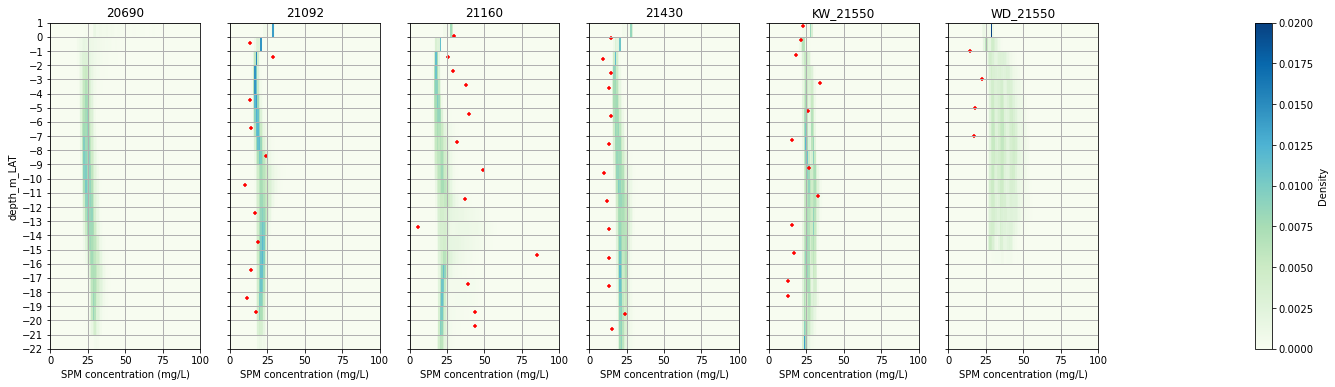

In [19]:
no_of_plots = len(spmc_assmeblage_files_for_profileplot)
fig, ax = plt.subplots(1, no_of_plots+1, figsize = (22,6), sharey = True)
for i in range(no_of_plots):
    # get campaign name
    campaign_no =  os.path.basename(os.path.dirname(spmc_assmeblage_files_for_profileplot[i])).replace('grid_Multiingest_0095_6565_','')
    # read raster and plot predicted SPMC histograms
    raster = xr.open_dataset(spmc_assmeblage_files_for_profileplot[i])
    df = raster[variable_for_profileplot].to_dataframe().reset_index().dropna()
    _,_,_,im = ax[i].hist2d(x = df[variable_for_profileplot], y = df['z'],
                 bins = [spmc_profile_plot_spmc_bins,
                         spmc_profile_plot_depth_bins],
                 cmap = 'GnBu',density = True,
                 vmin = 0., vmax = 0.02, 
                 rasterized=True)
    ax[i].set_title(campaign_no)
    # filter the nisking data to the campaign no and plot
    niskin[niskin.Campaign == campaign_no].plot.scatter(x = niskin_spmc_variable,
                                                        y = z_coord_LAT,
                                                        ax = ax[i], color = 'red', marker = '+')
    # put grid
    ax[i].set_yticks(spmc_profile_plot_depth_bins)
    ax[i].grid(axis='both', linewidth = 1)
ax[i+1].axis('off')
fig.colorbar(im, ax = ax[i+1], label = 'Density')
fig.savefig(filepath_spmc_profile_plot,bbox_inches='tight', dpi = 300)

### Export predicted SPMC statistics in a table

In [20]:
spmc_assemblage_files = glob(f'{raster_path}/*/*_SPMC_(0.0,_459.0].nc')
results = []
for spmc_assemblage_file in spmc_assemblage_files:
    raster = xr.open_dataset(spmc_assemblage_file)
    result = pd.DataFrame(
        {'depth (m lat)': raster['SPMC_(0.0,_459.0]_mean'].z.data,
         'Min of SPMC_(0.0,_459.0]_mean':raster['SPMC_(0.0,_459.0]_mean'].groupby('z').min(('x', 'y')).data,
         'Mean of SPMC_(0.0,_459.0]_mean':raster['SPMC_(0.0,_459.0]_mean'].groupby('z').mean(('x', 'y')).data,
         'Max of SPMC_(0.0,_459.0]_mean':raster['SPMC_(0.0,_459.0]_mean'].groupby('z').max(('x', 'y')).data,
         'campaign': os.path.basename(os.path.dirname(spmc_assemblage_file))}
        )
    result.set_index('campaign', inplace=True)
    results.append(result)
spmc_stats_per_depth = pd.concat(results)
spmc_stats_per_depth.to_csv(filename_spmc_table)
spmc_stats_per_depth

,depth (m lat),"Min of SPMC_(0.0,_459.0]_mean","Mean of SPMC_(0.0,_459.0]_mean","Max of SPMC_(0.0,_459.0]_mean"
campaign,,,,
grid_Multiingest_0095_6565_20690,-22.0,9.594894,30.878280,46.545531
grid_Multiingest_0095_6565_20690,-21.0,9.557266,29.584372,51.105209
grid_Multiingest_0095_6565_20690,-20.0,11.783794,29.611250,130.476714
grid_Multiingest_0095_6565_20690,-19.0,14.240589,30.255160,60.855352
grid_Multiingest_0095_6565_20690,-18.0,16.033488,30.432266,51.649814
...,...,...,...,...
grid_Multiingest_0095_6565_WD_21550,-4.0,12.137472,36.228147,105.232613
grid_Multiingest_0095_6565_WD_21550,-3.0,20.238298,35.153326,69.375525
grid_Multiingest_0095_6565_WD_21550,-2.0,18.761990,33.115938,59.209659


In [21]:
average_spmc_stats = spmc_stats_per_depth.groupby('campaign').mean()
average_spmc_stats.to_csv(filename_spmc_table_averages)
average_spmc_stats 

,depth (m lat),"Min of SPMC_(0.0,_459.0]_mean","Mean of SPMC_(0.0,_459.0]_mean","Max of SPMC_(0.0,_459.0]_mean"
campaign,,,,
grid_Multiingest_0095_6565_20690,-11.0,13.234777,27.923152,111.590113
grid_Multiingest_0095_6565_21092,-12.0,11.904067,20.803425,45.265402
grid_Multiingest_0095_6565_21160,-13.5,11.764139,23.101007,57.022959
grid_Multiingest_0095_6565_21430,-13.0,10.867581,21.408376,60.882506
grid_Multiingest_0095_6565_KW_21550,-12.5,12.351379,26.380737,61.220308
grid_Multiingest_0095_6565_WD_21550,-8.0,16.537178,35.540107,71.963388


## Plot colorscale for Potree figures

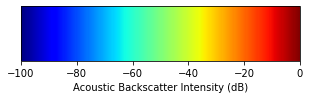

In [22]:
# create the colorbar instance
cmap = Dim2RgbaMapper(cmap_name = potree_cmap_name,
                    start_val = potree_value_db_min,
                    stop_val = potree_value_db_max)
# plot the colorbar
cmap.colorbar(potree_cmap_dimension)
plt.savefig(filepath_potree_colobar,bbox_inches='tight', dpi = 300)

## Optical Misalignment plot


Read in data files and do same preprocessing as in `2_lisst_preprocessing.ipynb`

In [23]:
# read in data files and combine
unprocessed_lisst_october = pd.read_csv(unprocessed_lisst_file_october)
unprocessed_lisst_october['campaign_month'] = 'October'
unprocessed_lisst_february = pd.read_csv(unprocessed_lisst_file_february)
unprocessed_lisst_february['campaign_month'] = 'February'
unprocessed_lisst = pd.concat([unprocessed_lisst_october, unprocessed_lisst_february])
# calculate datetime field from datetime_columns
unprocessed_lisst['datetime'] = pd.to_datetime(unprocessed_lisst[unprocessed_lisst_datetime_columns])
# Merge the LAT tide correction * sonarscope tide correction to the LISST FILE
unprocessed_lisst = unprocessed_lisst.merge(tide_proc, how = 'left', left_on = 'datetime', right_index = True)
# calculate the lisst depth in m LAT
unprocessed_lisst['Lisst_depth_m_LAT'] = unprocessed_lisst['waterniveau LAT smooth'] - unprocessed_lisst[unprocessed_lisst_z_coord]
# add depth bins
unprocessed_lisst['depth_bins_m_LAT'] = pd.cut(unprocessed_lisst['Lisst_depth_m_LAT'] , bins = psd_plot_depth_bins)
unprocessed_lisst_binned = unprocessed_lisst.groupby(['campaign_month','depth_bins_m_LAT']).mean().filter(like='Volume conc (microl/l)').transpose().set_index(size_classes.Median)

c:\Users\nore.praet\Anaconda3\envs\pcp-env2\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (76,84) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


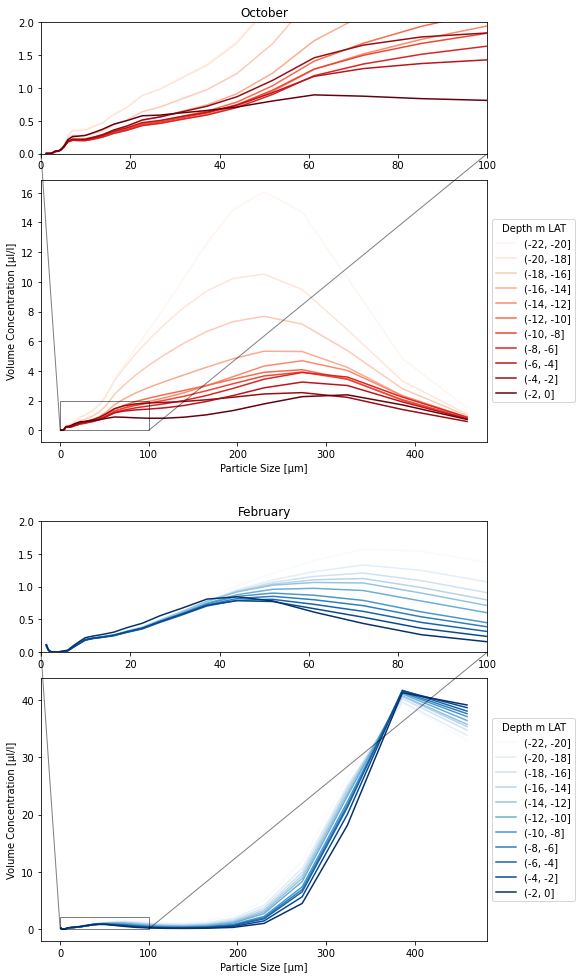

In [24]:
fig, ax = plt.subplots(2,1,figsize = (8,14))
unprocessed_lisst_binned['October'].plot(ax = ax[0], colormap='Reds')
ax[0].set_title('October')
ax[0].legend(title = 'Depth m LAT', loc='center left', bbox_to_anchor=(1, 0.5))
ax[0].set_ylabel('Volume Concentration [µl/l]')
ax[0].set_xlabel('Particle Size [µm]')
axins0 = ax[0].inset_axes([0, 1.1, 1, 0.5])
unprocessed_lisst_binned['October'].plot(ax = axins0, colormap='Reds', legend = False)
axins0.set_xlim(0, 100)
axins0.set_ylim(0, 2)
axins0.set_xlabel('')
ax[0].indicate_inset_zoom(axins0, edgecolor="black")

unprocessed_lisst_binned['February'].plot(ax = ax[1], colormap='Blues')
ax[1].set_title('February')
ax[1].legend(title = 'Depth m LAT', loc='center left', bbox_to_anchor=(1, 0.5))
ax[1].set_ylabel('Volume Concentration [µl/l]')
ax[1].set_xlabel('Particle Size [µm]')
axins1 = ax[1].inset_axes([0, 1.1, 1, 0.5])
unprocessed_lisst_binned['February'].plot(ax = axins1, colormap='Blues', legend = False)
axins1.set_xlim(0, 100)
axins1.set_ylim(0, 2)
axins1.set_xlabel('')
ax[1].indicate_inset_zoom(axins1, edgecolor="black")
fig.subplots_adjust(hspace=0.9)
fig.savefig(filepath_misalignment_plot,bbox_inches='tight')

## Table of predicted SPMC statistics per campaign

In [3]:
spmc_assemblage_files = glob(f'{raster_path}/*/*_SPMC_*.nc')
results = []
for spmc_assemblage_file in spmc_assemblage_files:
    campaign = os.path.basename(os.path.dirname(spmc_assemblage_file))
    raster = xr.open_dataset(spmc_assemblage_file)
    averages = raster.mean().to_pandas().drop('spatial_ref')
    result = pd.DataFrame(
        {'quantity':averages.index,
         'average_value':averages.values})
    result['campaign'] = campaign
    results.append(result)
    

In [4]:
spmc_average_table = pd.concat(results).pivot_table(values='average_value', index='campaign', columns='quantity').T
spmc_average_table.to_csv(filepath_spmc_average_table)
spmc_average_table


campaign,grid_Multiingest_0095_6565_20690,grid_Multiingest_0095_6565_21092,grid_Multiingest_0095_6565_21160,grid_Multiingest_0095_6565_21430,grid_Multiingest_0095_6565_KW_21550,grid_Multiingest_0095_6565_WD_21550
quantity,,,,,,
"SPMC_(0.0,_3.0]_ci_lower",0.006444,0.012244,0.010089,0.011312,0.006340,0.003269
"SPMC_(0.0,_3.0]_ci_upper",0.410417,0.790211,0.648772,0.727777,0.403293,0.211529
"SPMC_(0.0,_3.0]_mean",0.067198,0.128526,0.105713,0.118558,0.066074,0.034361
"SPMC_(0.0,_459.0]_ci_lower",6.617150,5.058260,5.713164,5.212977,6.517681,8.815812
"SPMC_(0.0,_459.0]_ci_upper",70.398337,53.811510,60.781163,55.456768,69.336592,93.810628
"SPMC_(0.0,_459.0]_mean",27.178556,20.775326,23.465647,21.410653,26.769331,36.213198
"SPMC_(20.0,_200.0]_ci_lower",0.500443,0.344250,0.411482,0.358587,0.486847,0.742384
"SPMC_(20.0,_200.0]_ci_upper",7.280809,5.008078,5.986470,5.216599,7.082534,10.802849
"SPMC_(20.0,_200.0]_mean",2.324555,1.598988,1.911320,1.665573,2.261325,3.448704
